In [1]:
!pip install shapely
!pip install geopandas
!pip install folium

     |████████████████████████████████| 1.0 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 962 kB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 50.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 2.1 MB/s eta 0:00:011


In [2]:
#import Libraries
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium

In [3]:
# The code was removed by Watson Studio for sharing.

,id,zip,province,district,lat,lng
0,1,10200,กรุงเทพมหานคร,พระนคร,13.756024,100.498679
1,2,10300,กรุงเทพมหานคร,ดุสิต,13.772694,100.509926
2,3,10530,กรุงเทพมหานคร,หนองจอก,13.855988,100.861969
3,4,10500,กรุงเทพมหานคร,บางรัก,13.726240,100.526799
4,5,10220,กรุงเทพมหานคร,บางเขน,13.864387,100.614643


In [4]:
#Processing Data
geo_data.rename(columns = {'zip': 'postcode'}, inplace = True)
geo_data['coordinates'] = list(zip(geo_data['lat'], geo_data['lng']))
geo_data['coordinates'] = geo_data['coordinates'].apply(Point)
geo_data.head()

,id,postcode,province,district,lat,lng,coordinates
0,1,10200,กรุงเทพมหานคร,พระนคร,13.756024,100.498679,POINT (13.7560243 100.4986793)
1,2,10300,กรุงเทพมหานคร,ดุสิต,13.772694,100.509926,POINT (13.7726943 100.5099262)
2,3,10530,กรุงเทพมหานคร,หนองจอก,13.855988,100.861969,POINT (13.8559883 100.8619689)
3,4,10500,กรุงเทพมหานคร,บางรัก,13.726240,100.526799,POINT (13.7262395 100.5267991)
4,5,10220,กรุงเทพมหานคร,บางเขน,13.864387,100.614643,POINT (13.864387 100.6146434)


In [5]:
# import map rendering library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON 
import geopy

# use geopy to obtain latitude/longitude of Toronto.
# coordinates will be used for map visualization

address = 'Bangkok, Thailand'

geolocator = geopy.Nominatim(user_agent="ny_explorer", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok 13.7538929, 100.8160803.


In [6]:
# create map of Toronto using latitude and longitude values
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map based on coordinates of postcode
for lat, lng, neighbourhood in zip(geo_data['lat'], geo_data['lng'], geo_data['district']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok)  
    
map_bangkok

In [8]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'JRG2WVLJKBPVXW3TB2L3NGNSGPNFBBGRDERMQU4OSN3ZMDQF' # your Foursquare ID
CLIENT_SECRET = 'H3DKQHPVZJJIPF4MKAK5AUJ3PNKAEVQ3OWPSY3ALCCUQWE23' # your Foursquare Secret
VERSION = '20161225' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JRG2WVLJKBPVXW3TB2L3NGNSGPNFBBGRDERMQU4OSN3ZMDQF
CLIENT_SECRET:H3DKQHPVZJJIPF4MKAK5AUJ3PNKAEVQ3OWPSY3ALCCUQWE23


In [9]:
# define limit = 50 (limit to 5 venues only) & radius = 5000 (meters)
LIMIT = 50
radius = 5000

location_list = [] # initiate a list to store data from Foursquare API requests

for neighbourhood, latitude, longitude in zip(geo_data.district, geo_data.lat, geo_data.lng):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
    data = requests.get(url).json()
    #print(data)
    # use len() to check if any data within "items" (len = 0 if nothing)
    length = len(data['response']['groups'][0]['items'])
    if length == 0:
        continue # skip the row if nothing is found
    else:
        venue = data['response']['groups'][0]['items'][0]['venue']
        
        # extract info within 'venue'
        name = venue['name']
        lat = venue['location']['lat']
        lon = venue['location']['lng']
        cat = venue['categories'][0]['name']
        
        location_list.append([(neighbourhood, latitude, longitude, name, lat, lon, cat)])

In [18]:
# create data frame based on 'Location_list'

temp = pd.DataFrame(x for row in location_list for x in row)
temp.columns = ['district','N_Latitude','N_Longitude','Venue','V_Latitude','V_Longitude','category']
temp.head()

#print("{} nearby locations downloaded for {} neighbourhood.".format(len(temp.Venue), len(geo_data.district)))

,district,N_Latitude,N_Longitude,Venue,V_Latitude,V_Longitude,category
0,พระนคร,13.756024,100.498679,Mont Nom Sod (มนต์นมสด),13.753972,100.501317,Bakery
1,ดุสิต,13.772694,100.509926,Amphorn Satharn Villa (พระที่นั่งอัมพรสถาน),13.772462,100.511298,Palace
2,หนองจอก,13.855988,100.861969,สวนสาธารณะหนองจอก,13.853778,100.859002,Park
3,บางรัก,13.726240,100.526799,Amara Bangkok,13.728673,100.527564,Hotel
4,บางเขน,13.864387,100.614643,Starbucks (สตาร์บัคส์),13.862239,100.612988,Coffee Shop


In [11]:
restaurant_cat = ['Bakery', 'Coffee Shop', 'Chinese Restaurant',
       'Ice Cream Shop', 'Hotpot Restaurant', 'Thai Restaurant', 'Bar',
       'Noodle House', 'Japanese Restaurant', 'BBQ Joint', 'Shabu-Shabu Restaurant',
       'Café', 'Beer Bar', 'Asian Restaurant', 'Halal Restaurant', 'Steakhouse',
       'Fast Food Restaurant']
temp_1 = temp[temp.category.isin(restaurant_cat)]
temp_1

array(['Bakery', 'Coffee Shop', 'Chinese Restaurant', 'Ice Cream Shop',
       'Hotpot Restaurant', 'Thai Restaurant', 'Bar', 'Noodle House',
       'Japanese Restaurant', 'BBQ Joint', 'Shabu-Shabu Restaurant',
       'Café', 'Beer Bar', 'Asian Restaurant', 'Halal Restaurant',
       'Steakhouse', 'Fast Food Restaurant'], dtype=object)

In [19]:
cat = pd.get_dummies(temp_1.category) # one hot encoding with get_dummies()
df_01 = pd.concat([temp_1[['district']], cat], axis=1) # combine neighbourhood & category tables
df_01.head()

,district,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,พระนคร,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,บางเขน,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,บางกะปิ,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,ป้อมปราบศัตรูพ่าย,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,พระโขนง,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Cluster Analysis

In [20]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [21]:
df_02 = df_01.drop('district', axis=1)

n_group = 6 # we will group neighbourhoods into 6 clusters

# run k-means clustering
kmeans = KMeans(n_clusters=n_group, random_state=0).fit(df_02)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_01.insert(1, 'label', kmeans.labels_)

df_01.head() 


,district,label,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,พระนคร,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,บางเขน,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,บางกะปิ,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,ป้อมปราบศัตรูพ่าย,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,พระโขนง,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [22]:
bkk_merged = pd.merge(geo_data, df_01, on='district', how='right')
bkk_merged.head()

,id,postcode,province,district,lat,lng,coordinates,label,Asian Restaurant,BBQ Joint,...,Coffee Shop,Fast Food Restaurant,Halal Restaurant,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Noodle House,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant
0,1,10200,กรุงเทพมหานคร,พระนคร,13.756024,100.498679,POINT (13.7560243 100.4986793),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,10220,กรุงเทพมหานคร,บางเขน,13.864387,100.614643,POINT (13.864387 100.6146434),2,0,0,...,1,0,0,0,0,0,0,0,0,0
2,6,10240,กรุงเทพมหานคร,บางกะปิ,13.765028,100.647389,POINT (13.7650282 100.6473885),3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,10100,กรุงเทพมหานคร,ป้อมปราบศัตรูพ่าย,13.751495,100.510848,POINT (13.7514954 100.5108479),2,0,0,...,1,0,0,0,0,0,0,0,0,0
4,9,10260,กรุงเทพมหานคร,พระโขนง,13.691065,100.614025,POINT (13.6910654 100.614025),5,0,0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
from matplotlib import cm, colors
import folium

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n_group)
ys = [i + x + (i*x)**2 for i in range(n_group)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bkk_merged['lat'], bkk_merged['lng'], bkk_merged['district'], bkk_merged['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

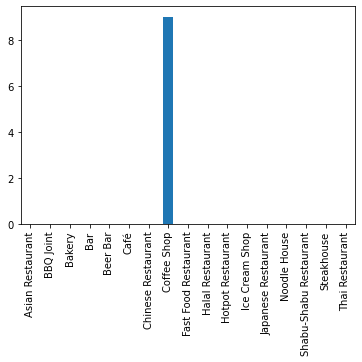

In [39]:
bar_temp = bkk_merged.loc[bkk_merged['label'] == 2, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]
bar_temp.drop(['postcode', 'lng', 'coordinates', 'label'], axis=1, inplace=True)
bar_temp1 = bar_temp.sum()
bar_temp1.plot.bar()

In [45]:
def plot_hot_code(cat):
    bar_temp = bkk_merged.loc[bkk_merged['label'] == cat, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]
    bar_temp.drop(['postcode', 'lng', 'coordinates', 'label'], axis=1, inplace=True)
    bar_temp1 = bar_temp.sum()
    bar_temp1.plot.bar()


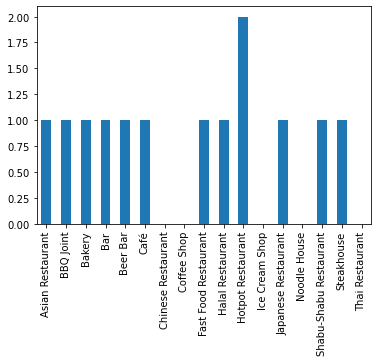

In [47]:
plot_hot_code(0)

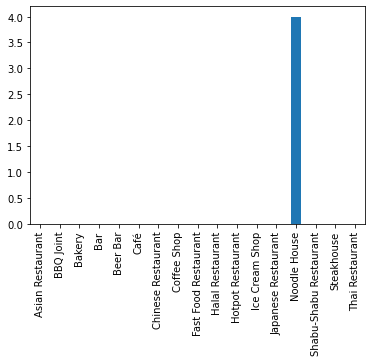

In [48]:
plot_hot_code(1)

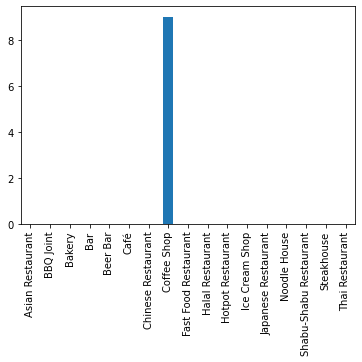

In [49]:
plot_hot_code(2)

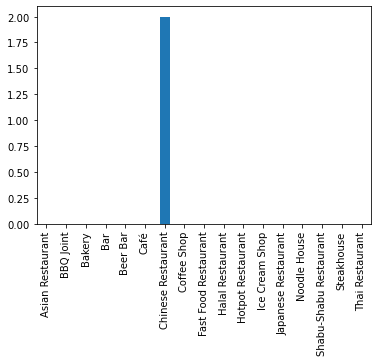

In [50]:
plot_hot_code(3)

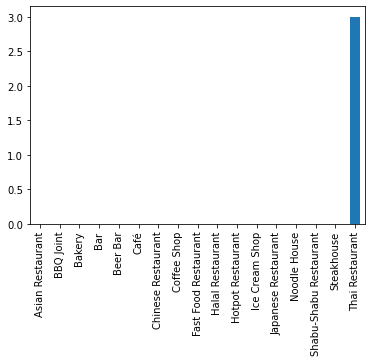

In [51]:
plot_hot_code(4)

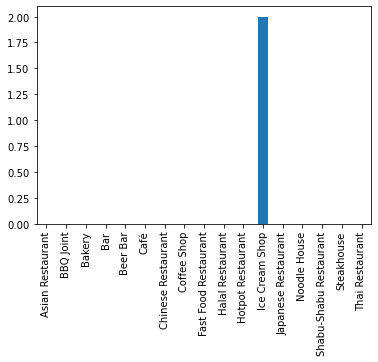

In [52]:
plot_hot_code(5)

In [60]:
!pip install googletrans

     |████████████████████████████████| 55 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 972 kB 21.1 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 4.3 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 7.0 MB/s  eta 0:00:01
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=85158dc721fca89706c519580ca25fe56aa1acc5f9cd01a45db5b6031437c360
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [68]:
from googletrans import Translator
translator = Translator()

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n_group)
ys = [i + x + (i*x)**2 for i in range(n_group)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
cluster_name = ['All kind of food', 'noodle house', 'coffee shop', 'Thai restaurant', 'icecream Shop']
markers_colors = []
for lat, lon, poi, cluster in zip(bkk_merged['lat'], bkk_merged['lng'], bkk_merged['district'], bkk_merged['label']):
    label = folium.Popup(translator.translate(poi).text + '\n Best for ' + cluster_name[cluster-1], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters